In [1]:
# Data preprocessing, math and plotting
import os
import numpy as np 
import pandas as pd 
from scipy import stats 
import matplotlib.pyplot as plt
import seaborn as sns 

# ML 
import sklearn
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, auc, classification_report
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize
from sklearn.metrics import r2_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import datetime
import random
import warnings
warnings.filterwarnings('ignore')

#### Reading in all the data 

In [2]:
customers_df = pd.read_csv(r'data/olist_customers_dataset.csv')
geolocation_df = pd.read_csv(r'data/olist_geolocation_dataset.csv') # drop
orders_df = pd.read_csv(r'data/olist_orders_dataset.csv')
order_items_df = pd.read_csv(r'data/olist_order_items_dataset.csv')
order_payments_df = pd.read_csv(r'data/olist_order_payments_dataset.csv')
reviews_df = pd.read_csv(r'data/olist_order_reviews_dataset.csv') 
products_df = pd.read_csv(r'data/olist_products_dataset.csv')
sellers_df = pd.read_csv(r'data/olist_sellers_dataset.csv') 
category_names_translated_df = pd.read_csv(r'data/product_category_name_translation.csv') 
# Get product category translation
products_translated_df = category_names_translated_df.merge(products_df, on='product_category_name', how='left')
products_translated_df.drop(products_translated_df.columns[[0]], axis=1, inplace=True)

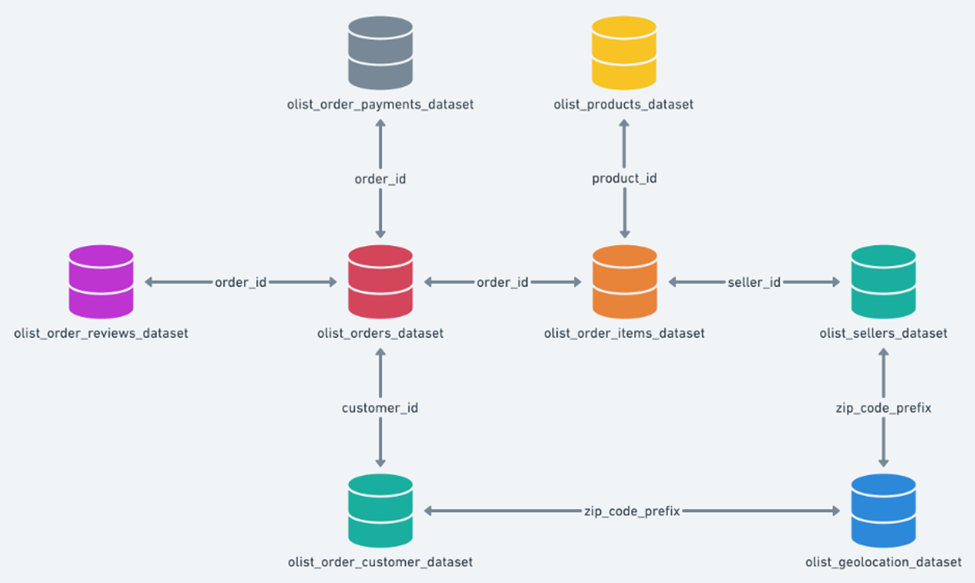

#### Merging the datasets

In [3]:
# Get product category translation
merged_df = orders_df.merge(order_items_df, on='order_id', how='left')
merged_df = merged_df.merge(order_payments_df, on='order_id', how='outer', validate='m:m')
merged_df = merged_df.merge(reviews_df, on='order_id', how='outer')
merged_df = merged_df.merge(customers_df, on='customer_id', how='outer')
merged_df = merged_df.merge(sellers_df, on='seller_id', how='outer')
merged_df = merged_df.merge(products_translated_df, on='product_id', how='outer')

#### Display shape of the dataset, along with all field names and their respective datatypes, number of missing values, number of unique values, first value in the dataset, and feature entropy.

In [4]:
def resumetable(df):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values    
    summary['Uniques'] = df.nunique().values
    summary['First Value'] = df.loc[0].values

    for name in summary['Name'].value_counts().index:
        summary.loc[summary['Name'] == name, 'Entropy'] = round(stats.entropy(df[name].value_counts(normalize=True), base=2),2) 

    return summary

def data_types(df):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]

    return summary

resumetable(merged_df)

Dataset Shape: (119143, 39)


,Name,dtypes,Missing,Uniques,First Value,Entropy
0,order_id,object,0,99441,e481f51cbdc54678b7cc49136f2d6af7,16.46
1,customer_id,object,0,99441,9ef432eb6251297304e76186b10a928d,16.46
2,order_status,object,0,8,delivered,0.25
3,order_purchase_timestamp,object,0,98875,2017-10-02 10:56:33,16.44
4,order_approved_at,object,177,90733,2017-10-02 11:07:15,16.28
5,order_delivered_carrier_date,object,2086,81018,2017-10-04 19:55:00,16.03
6,order_delivered_customer_date,object,3421,95664,2017-10-10 21:25:13,16.40
7,order_estimated_delivery_date,object,0,459,2017-10-18 00:00:00,8.47
8,order_item_id,float64,833,21,1.0,0.72
9,product_id,object,833,32951,87285b34884572647811a353c7ac498a,13.63


### Cleaning the data

In [5]:
# Need to convert datetime features to the correct format

show_original_dtypes = data_types(merged_df)

merged_df.order_purchase_timestamp = pd.to_datetime(merged_df.order_purchase_timestamp)
merged_df.order_approved_at = pd.to_datetime(merged_df.order_approved_at)
merged_df.order_delivered_carrier_date = pd.to_datetime(merged_df.order_delivered_carrier_date)
merged_df.order_estimated_delivery_date = pd.to_datetime(merged_df.order_estimated_delivery_date)
merged_df.order_delivered_customer_date = pd.to_datetime(merged_df.order_delivered_customer_date)
merged_df.review_creation_date = pd.to_datetime(merged_df.review_creation_date)
merged_df.review_answer_timestamp = pd.to_datetime(merged_df.review_answer_timestamp)
merged_df.shipping_limit_date = pd.to_datetime(merged_df.shipping_limit_date)

# Show/validate changed data types
show_new_dtypes = data_types(merged_df)
compare_dtypes = show_original_dtypes.merge(show_new_dtypes, on='Name', how='outer')
different_dtypes = compare_dtypes[compare_dtypes['dtypes_x'] != compare_dtypes['dtypes_y']]
different_dtypes

Dataset Shape: (119143, 39)
Dataset Shape: (119143, 39)


,Name,dtypes_x,dtypes_y
3,order_purchase_timestamp,object,datetime64[ns]
4,order_approved_at,object,datetime64[ns]
5,order_delivered_carrier_date,object,datetime64[ns]
6,order_delivered_customer_date,object,datetime64[ns]
7,order_estimated_delivery_date,object,datetime64[ns]
11,shipping_limit_date,object,datetime64[ns]
22,review_creation_date,object,datetime64[ns]
23,review_answer_timestamp,object,datetime64[ns]


In [9]:
merged_df

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,...,seller_city,seller_state,product_category_name_english,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,1.0,87285b34884572647811a353c7ac498a,...,maua,SP,housewares,40.0,268.0,4.0,500.0,19.0,8.0,13.0
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,1.0,87285b34884572647811a353c7ac498a,...,maua,SP,housewares,40.0,268.0,4.0,500.0,19.0,8.0,13.0
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,1.0,87285b34884572647811a353c7ac498a,...,maua,SP,housewares,40.0,268.0,4.0,500.0,19.0,8.0,13.0
3,128e10d95713541c87cd1a2e48201934,a20e8105f23924cd00833fd87daa0831,delivered,2017-08-15 18:29:31,2017-08-15 20:05:16,2017-08-17 15:28:33,2017-08-18 14:44:43,2017-08-28,1.0,87285b34884572647811a353c7ac498a,...,maua,SP,housewares,40.0,268.0,4.0,500.0,19.0,8.0,13.0
4,0e7e841ddf8f8f2de2bad69267ecfbcf,26c7ac168e1433912a51b924fbd34d34,delivered,2017-08-02 18:24:47,2017-08-02 18:43:15,2017-08-04 17:35:43,2017-08-07 18:30:01,2017-08-15,1.0,87285b34884572647811a353c7ac498a,...,maua,SP,housewares,40.0,268.0,4.0,500.0,19.0,8.0,13.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119138,1ab38815794efa43d269d62b98dae815,a0b67404d84a70ef420a7f99ad6b190a,delivered,2018-07-01 10:23:10,2018-07-05 16:17:52,2018-07-04 14:34:00,2018-07-09 15:06:57,2018-07-20,1.0,31ec3a565e06de4bdf9d2a511b822b4d,...,porto ferreira,SP,construction_tools_lights,40.0,516.0,2.0,750.0,30.0,28.0,28.0
119139,b159d0ce7cd881052da94fa165617b05,e0c3bc5ce0836b975d6b2a8ce7bb0e3e,canceled,2017-03-11 19:51:36,2017-03-11 19:51:36,NaT,NaT,2017-03-30,1.0,241a1ffc9cf969b27de6e72301020268,...,blumenau,SC,auto,48.0,260.0,2.0,400.0,16.0,4.0,11.0
119140,735dce2d574afe8eb87e80a3d6229c48,d531d01affc2c55769f6b9ed410d8d3c,delivered,2018-07-24 09:46:27,2018-07-24 11:24:27,2018-07-24 15:14:00,2018-08-02 22:47:35,2018-08-16,1.0,1d187e8e7a30417fda31e85679d96f0f,...,americana,SP,furniture_decor,43.0,729.0,2.0,2100.0,80.0,8.0,30.0
119141,25d2bfa43663a23586afd12f15b542e7,9d8c06734fde9823ace11a4b5929b5a7,delivered,2018-05-22 21:13:21,2018-05-22 21:35:40,2018-05-24 12:28:00,2018-06-12 23:11:29,2018-06-08,1.0,6e1c2008dea1929b9b6c27fa01381e90,...,sao paulo,SP,furniture_decor,19.0,531.0,1.0,5900.0,41.0,21.0,41.0


In [10]:
# creating an aggregation
avg_score_per_category = merged_df.groupby('product_category_name_english', as_index=False).agg({'review_score': ['count', 'mean']})
avg_score_per_category.columns = ['product_category_name_english', 'count', 'mean']

,product_category_name_english,count,mean
8,books_general_interest,561,4.438503
9,books_imported,62,4.419355
22,costruction_tools_tools,101,4.415842
10,books_technical,269,4.375465
37,food_drink,290,4.324138
64,small_appliances_home_oven_and_coffee,78,4.320513
53,luggage_accessories,1159,4.295945
36,food,511,4.228963
31,fashion_shoes,273,4.223443
13,cine_photo,74,4.216216


#### What is the average review (1-5 stars) for each product category

In [15]:
# creating an aggregation
avg_score_per_category = merged_df.groupby('product_category_name_english', as_index=False).agg({'review_score': ['count', 'mean']})
avg_score_per_category.columns = ['product_category_name_english', 'count', 'mean']


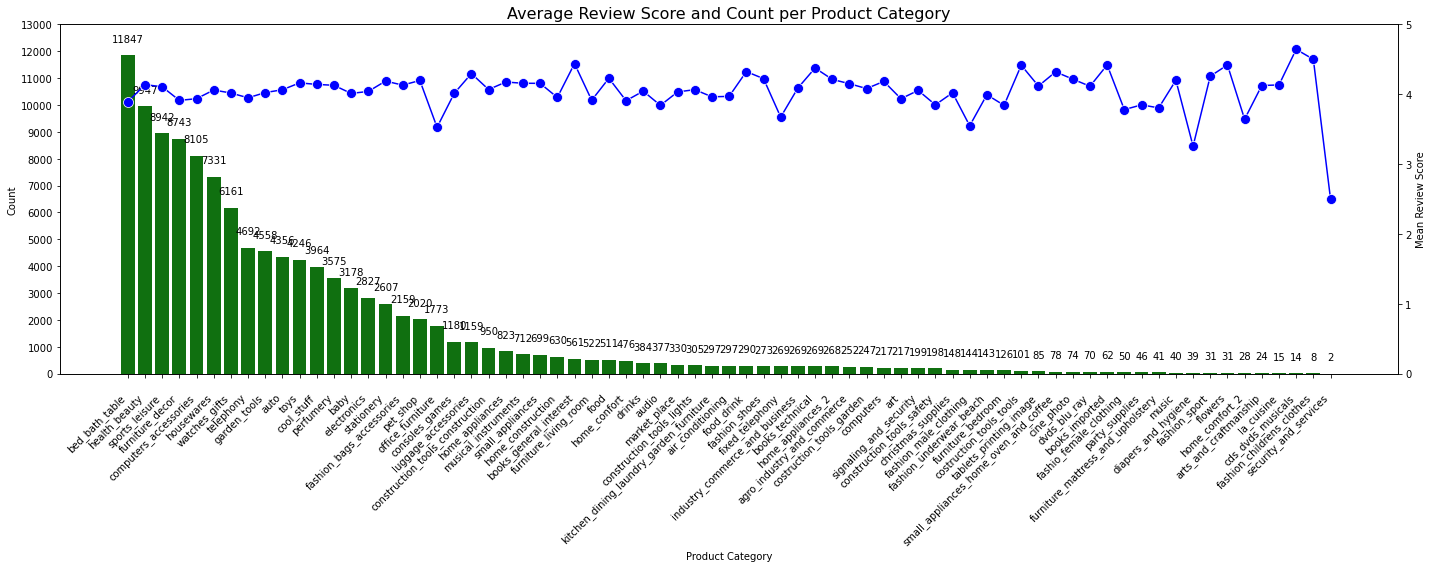

In [18]:
# sort the dataframe by mean review score in descending order
avg_score_per_category = avg_score_per_category.sort_values('count', ascending=False)

# create the figure and axes objects
fig, ax1 = plt.subplots(figsize=(20, 8))
ax2 = ax1.twinx()

# create the bar plots for counts and mean
sns.barplot(x='product_category_name_english', y='count', data=avg_score_per_category, color='green', ax=ax1)
sns.lineplot(x='product_category_name_english', y='mean', data=avg_score_per_category, color='blue', marker='o', markersize=10, ax=ax2)

# add count labels on top of the bars
for i, v in enumerate(avg_score_per_category['count']):
    ax1.text(i, v + 500, str(v), color='black', ha='center')

# set the y-axis labels and tick labels
ax2.set_ylabel('Mean Review Score')
ax1.set_ylabel('Count')
ax1.set_yticks(range(0, 13001, 1000))
ax1.set_ylim(0, 13000)
ax2.set_yticks(range(0, 6))
ax2.set_ylim(0, 5)

# set the x-axis labels and tick labels
ax1.set_xlabel('Product Category')
ax1.set_xticklabels(avg_score_per_category['product_category_name_english'], rotation=45, ha='right')

# adjust the position and angle of the x-tick labels
ax1.tick_params(axis='x', which='major', pad=15, rotation=45)

# add titles
ax1.set_title('Average Review Score and Count per Product Category', fontsize=16)

plt.tight_layout()
plt.show()

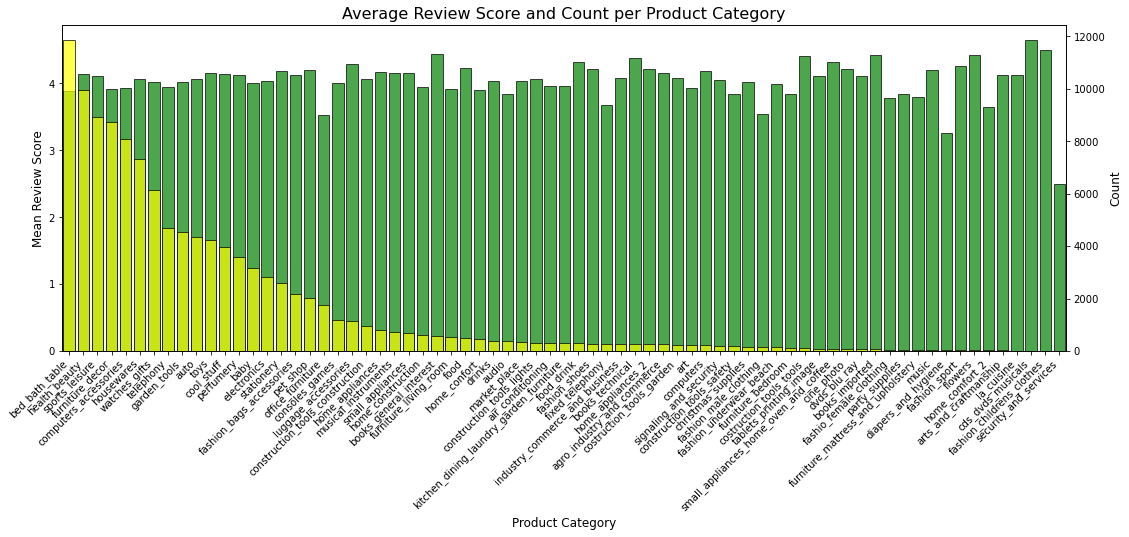

In [19]:
# sort the dataframe by mean review score in descending order
avg_score_per_category = avg_score_per_category.sort_values('count', ascending=False)

# create the figure and axis objects
fig, ax1 = plt.subplots(figsize=(18, 6))
ax2 = ax1.twinx()

# create the first bar for mean review score
ax1.bar(avg_score_per_category['product_category_name_english'], avg_score_per_category['mean'], color='green', alpha=0.7, edgecolor='black')
ax1.set_ylabel('Mean Review Score', fontsize=12)

# create the second bar for count
ax2.bar(avg_score_per_category['product_category_name_english'], avg_score_per_category['count'], color='yellow', alpha=0.7, edgecolor='black')
ax2.set_ylabel('Count', fontsize=12)

# add titles and labels
ax1.set_title('Average Review Score and Count per Product Category', fontsize=16)
ax1.set_xlabel('Product Category', fontsize=12)

# rotate and space out x-axis labels
ax1.set_xticklabels(avg_score_per_category['product_category_name_english'], rotation=45, ha='right')
ax1.set_xlim(-0.5, len(avg_score_per_category) - 0.5)

# display the plot
plt.show()

Ideas (to-do)

Correlation of product category sales and months/seasons
